# What happens if I fit a mass-gainer with single star models?

In [11]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from scipy.interpolate import interp1d

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

In [12]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [13]:
from importlib import reload
import sys
sys.path.append("../../")

import mesagrid
reload(mesagrid);

sys.path.append("../../helpers")
import mpt

In [14]:
from types import ModuleType
def refresh_mpt():
    rreload(mpt)
    rreload(mpt)

def rreload(module):
    """Recursively reload modules."""
    reload(module)
    for attribute_name in dir(module):
        attribute = getattr(module, attribute_name)
        if type(attribute) is ModuleType:
            if attribute_name in ["hr", "profiles", "period_spacing", "utils"]:
                rreload(attribute)

In [15]:
track = mesagrid.Track("../../output/cluster/binaries/Dmix_grid/D_20", dir_name="LOGS_star2", parameters="Mass-gainer")

In [16]:
single_tracks = {}
Ms = np.arange(3.0, 6.1, 0.1)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks[folder] = mesagrid.Track(dir=f"../../output/cluster/singles_grid_mdm20/{folder}", parameters=folder)
mod_names = [f"M_{M:1.1f}" for M in Ms]

In [17]:
def chi2_2D(p_mg, dp_mg, p_s, dp_s, norm=None):
    if norm is None:
        norm = (dp_mg.max() - dp_mg.min()) / (p_mg.max() - p_mg.min())

    p_mg, dp_mg, p_s, dp_s = p_mg.value, dp_mg.value, p_s.value, dp_s.value

    p_diff = (p_mg[:, None] - p_s[None, :])**2
    dp_diff = ((p_mg[:, None] - p_s[None, :]) / norm)**2

    chi2 = np.min(p_diff + dp_diff, axis=1).sum()

    # sanity check
    assert np.isfinite(chi2)

    return chi2

In [18]:
import astropy.units as u
import numpy as np
from scipy.optimize import linear_sum_assignment
from itertools import product

def chi_period(p_s, p_mg=None, x=None, p_min=1.0, n_modes=20):
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods and remove units
        p_mg = np.sort(p_mg.to(u.d).value)

        # take the first n modes after period p_min
        x = p_mg[p_mg > p_min][:n_modes]

    # sort single star periods and remove units
    p_s = np.sort(p_s.to(u.d).value)

    # find the closest period to the starting mass-gainer period 
    # ------------ THIS FEELS LIKE IT COULD BE WRONG -----------
    y_start = np.abs(p_s - x[0]).argmin()

    # get the 20 modes after this matching period
    y = p_s[y_start:y_start + n_modes]

    # if for some reason there aren't 20 modes in either case then return infinity
    if len(y) != len(x) or len(x) != n_modes or len(y) != n_modes:
        return np.inf
    
    # calculate the cost matrix for the periods
    cost_matrix = np.zeros((len(x), len(y)))
    x_ind, y_ind = np.arange(len(x)), np.arange(len(y))
    for i, j in product(x_ind, y_ind):
        cost_matrix[i, j] = abs(x[i] - y[j])

    # use scipy to find the optimal assignment of modes
    opt_assignment = linear_sum_assignment(cost_matrix)

    # calculate chi^2
    measured_periods = x[opt_assignment[0]]
    model_periods = y[opt_assignment[1]]
    return np.sum((measured_periods - model_periods)**2)

[[0, 1], [2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [33, 34]]
[[2, 3], [5, 6, 7], [9, 10], [12, 13], [15, 16], [18, 19], [21, 22], [24, 25], [27, 28], [30, 31], [33, 34], [36, 37], [39, 40], [42, 43], [45, 46], [48, 49], [51, 52]]
1.0
0.0005764561886787551
0.0005764561886787551 

1.0
0.00019791843227257177
0.00019791843227257177 

1.0
0.0001466622665295662
0.0001466622665295662 

1.0
0.0002500779325726728
0.0002500779325726728 

1.0
0.00030989956573465854
0.00030989956573465854 

1.0
0.00013779178076702897
0.00013779178076702897 

1.0
2.0252189721990358e-05
2.0252189721990358e-05 

1.0
1.700721896003011e-05
1.700721896003011e-05 

1.0
9.159122763903831e-05
9.159122763903831e-05 

1.0
0.0002513375485950521
0.0002513375485950521 

1.0
0.00020749385896467437
0.00020749385896467437 

1.0
0.0001118719312854332
0.0001118719312854332 

1.0
0.0001486812440149422
0.0001486812440149422 

1.0
0.

1.700721896003011e-05

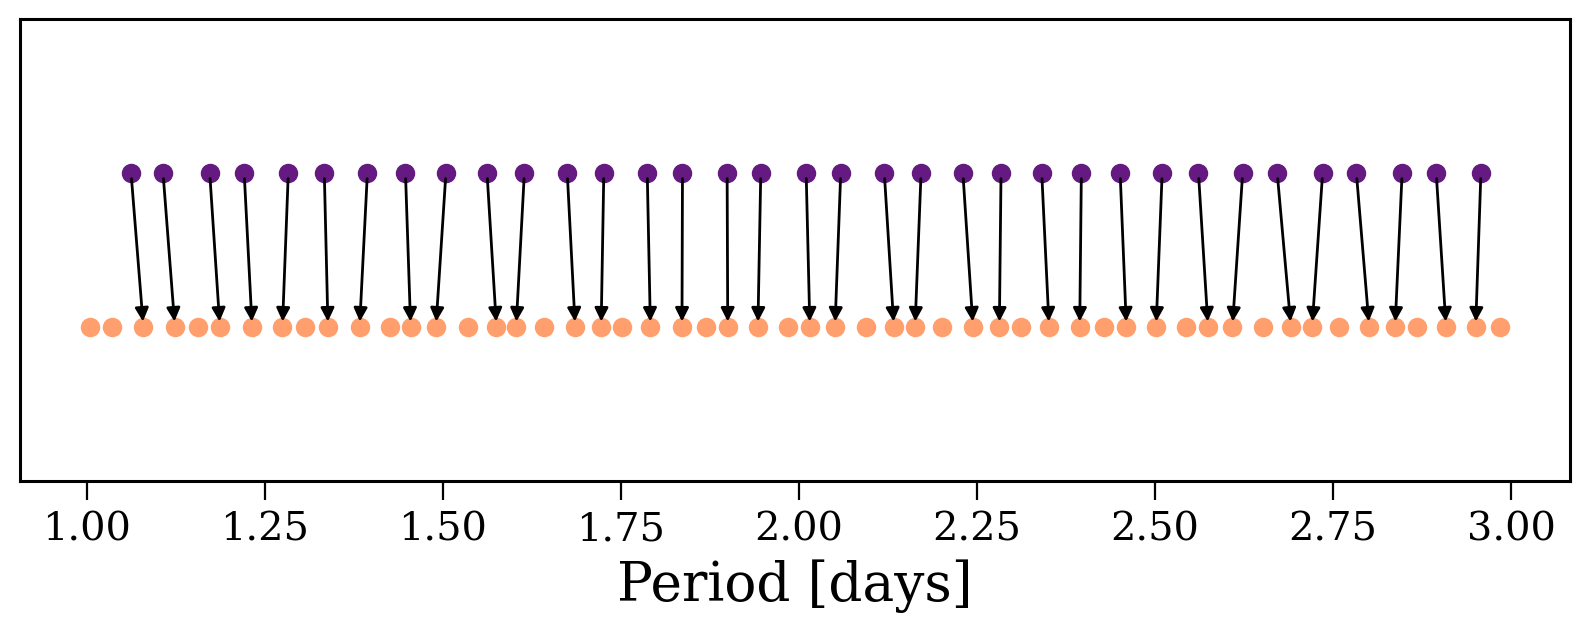

In [84]:
def chi_cole_old(p_s, p_mg=None, x=None, p_min=1.0, p_max=3.0, longest_chain=False):
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods, remove units, limit period range
        p_mg = np.sort(p_mg.to(u.d).value)
        p_mg = p_mg[(p_mg > p_min) & (p_mg <= p_max)]
    else:
        p_mg = x

    # sort single star periods, remove units, limit period range
    p_s = np.sort(p_s.to(u.d).value)
    p_s = p_s[(p_s > p_min) & (p_s <= p_max)]

    # indices of closest single star periods to each mass-gainer period
    inds_s = np.asarray([np.argmin(np.abs(p_s - p)) for p in p_mg])

    # empty arrays for storing length and chi2 of chains, cursor for tracking
    lengths = np.zeros(1000).astype(int)
    chi2 =  np.zeros(1000)
    cursor = 0

    ## we are going to loop over the indices and sum chi^2 for contiguous blocks, storing that chi^2 + length
    # base condition
    lengths[0] += 1
    chi2[0] += (p_s[inds_s[0]] - p_mg[0])**2

    inds_arrs = []
    curr_inds = [inds_s[0]]

    indmg_arrs = []
    curr_mg_inds = [0]
    for i in range(1, len(p_mg)):
        if inds_s[i] - inds_s[i - 1] == 1:
            curr_inds.append(inds_s[i])
            curr_mg_inds.append(i)
        else:
            inds_arrs.append(curr_inds)
            indmg_arrs.append(curr_mg_inds)
            cursor += 1
            curr_inds = [inds_s[i]]
            curr_mg_inds = [i]
        lengths[cursor] += 1
        chi2[cursor] += (p_mg[i] - p_s[inds_s[i]])**2
    inds_arrs.append(curr_inds)
    indmg_arrs.append(curr_mg_inds)

    # print(inds_s)
    print(indmg_arrs)
    print(inds_arrs)

    plt.figure(figsize=(10, 3))
    plt.scatter(p_s, np.zeros_like(p_s), color=mpt.single_col)
    plt.scatter(p_mg, np.ones_like(p_mg), color=mpt.mass_gainer_col)
    for i, ind in enumerate(inds_s):
        plt.annotate("", xytext=(p_mg[i], 1), xy=(p_s[ind], 0), arrowprops=dict(arrowstyle="-|>", color="black"))


    for i in range(len(indmg_arrs)):
        print(sum((p_mg[indmg_arrs[i]] - p_s[inds_arrs[i]])**2) / chi2[i])
        print(sum((p_mg[indmg_arrs[i]] - p_s[inds_arrs[i]])**2) / (len(indmg_arrs[i]) - 1))
        print(chi2[i] / (lengths[i] - 1), '\n')

    plt.ylim(-1, 2)
    plt.yticks([])
    plt.xlabel("Period [days]")

    # trim extra fat
    chi2 = chi2[:cursor + 1]
    lengths = lengths[:cursor + 1]

    # keep only chains with at least two periods
    chi2 = chi2[lengths > 1]
    lengths = lengths[lengths > 1]

    # convert to reduced chi2
    reduced_chi2 = chi2 / (lengths - 1)**2

    # just in case no chains were found
    if len(reduced_chi2) < 1:
        return 1e10
    
    loc = np.argmin(reduced_chi2)
    print(inds_arrs[loc], indmg_arrs[loc])

    # either return the chi2 of longest chain or just the minimum
    if longest_chain:
        return reduced_chi2[np.argmin(lengths)]
    else:
        return min(reduced_chi2)

p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
# p_s = mpt.get_delta_p(single_tracks["M_3.5"], mod=127)[0]
p_s = mpt.get_delta_p(single_tracks["M_6.0"], mod=168)[0]

chi_cole_old(p_s, p_mg)

In [154]:
def chi_cole(p_s, p_mg=None, x=None, p_min=1.0, p_max=3.0, longest_chain=False, chain_min=4, length_power=3):
    # if x is not directly supplied then compute it
    if x is None:
        # sort mass-gainer periods, remove units, limit period range
        p_mg = np.sort(p_mg.to(u.d).value)
        p_mg = p_mg[(p_mg > p_min) & (p_mg <= p_max)]
    else:
        p_mg = x

    # sort single star periods, remove units, limit period range
    p_s = np.sort(p_s.to(u.d).value)
    p_s = p_s[(p_s > p_min) & (p_s <= p_max)]

    # indices of closest single star periods to each mass-gainer period
    inds_s = np.asarray([np.argmin(np.abs(p_s - p)) for p in p_mg])

    # empty arrays for storing length and chi2 of chains, cursor for tracking
    # arrays are way too big to avoid growing them, will trim after
    BIG_BUT_RANDOM_NUMBER = 1000
    lengths = np.zeros(BIG_BUT_RANDOM_NUMBER)
    chi2 =  np.zeros(BIG_BUT_RANDOM_NUMBER)
    cursor = 0

    ## we are going to loop over the indices and sum chi^2 for contiguous blocks, storing that chi^2 + length
    # base condition
    lengths[0] += 1
    chi2[0] += (p_s[inds_s[0]] - p_mg[0])**2

    # step through each mass-gainer period
    for i in range(1, len(p_mg)):
        # if the closest single star period is not *also* the next radial order then start a new chain
        if inds_s[i] - inds_s[i - 1] != 1:
            cursor += 1

        # increment the length of the current chain and add to its chi^2
        lengths[cursor] += 1
        chi2[cursor] += (p_s[inds_s[i]] - p_mg[i])**2

    cursor = 1 if cursor == 0 else cursor

    # trim useless empty part of array
    chi2 = chi2[:cursor]
    lengths = lengths[:cursor]

    # keep only chains with at least two periods
    chi2 = chi2[lengths > chain_min]
    lengths = lengths[lengths > chain_min]

    # convert to reduced chi2
    reduced_chi2 = chi2 / (lengths - 1)**length_power

    # just in case no chains were found
    if len(reduced_chi2) < 1:
        return 1e10

    # either return the chi2 of longest chain or just the minimum
    if longest_chain:
        return reduced_chi2[np.argmin(lengths)]
    else:
        return min(reduced_chi2)

p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
p_s = mpt.get_delta_p(single_tracks["M_6.0"], mod=168)[0]

chi_cole(p_s, p_mg)

10000000000.0

In [ ]:
%%timeit
chi_period(p_s, p_mg=p_mg)

272 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%%timeit
chi_cole(p_s, p_mg)

256 µs ± 542 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [167]:
%%time
p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
p_mg = np.sort(p_mg.to(u.d).value)
x = p_mg[p_mg > 1.0][:20]

chis = [[chi_period(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x) for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]

CPU times: user 16.7 s, sys: 19.5 ms, total: 16.7 s
Wall time: 16.7 s


In [161]:
%%time
p_mg, _, _ = mpt.get_delta_p(track, X_c=0.1)
p_mg = np.sort(p_mg.to(u.d).value)
x = p_mg[(p_mg > 1.0) & (p_mg <= 3.0)]

chis = [[chi_cole(p_s=mpt.get_delta_p(single_tracks[mod_name], mod=i)[0], x=x)
         for i in range(len(single_tracks[mod_name].freqs))] for mod_name in mod_names]


CPU times: user 16.5 s, sys: 9.13 ms, total: 16.5 s
Wall time: 16.5 s


In [168]:
x_cs = [single_tracks[mod_name].history["center_h1"].values for mod_name in mod_names]

chi_funcs = [interp1d(x_c, chi, fill_value="extrapolate") for x_c, chi in zip(x_cs, chis)]

x_c_range = np.linspace(1e-5, 0.698, 5000)

XC, M = np.meshgrid(x_c_range, Ms)

CHI = np.asarray([chi_funcs[i](x_c_range) for i in range(len(chi_funcs))])
# CHI[CHI > 1] = np.inf

In [166]:
x_c_range[x_c_ind]

0.05795475895179036

In [171]:
0.7 / 1000

0.0007

In [173]:
x_c_range[x_c_ind] -0.7 / 1000

0.05725475895179036

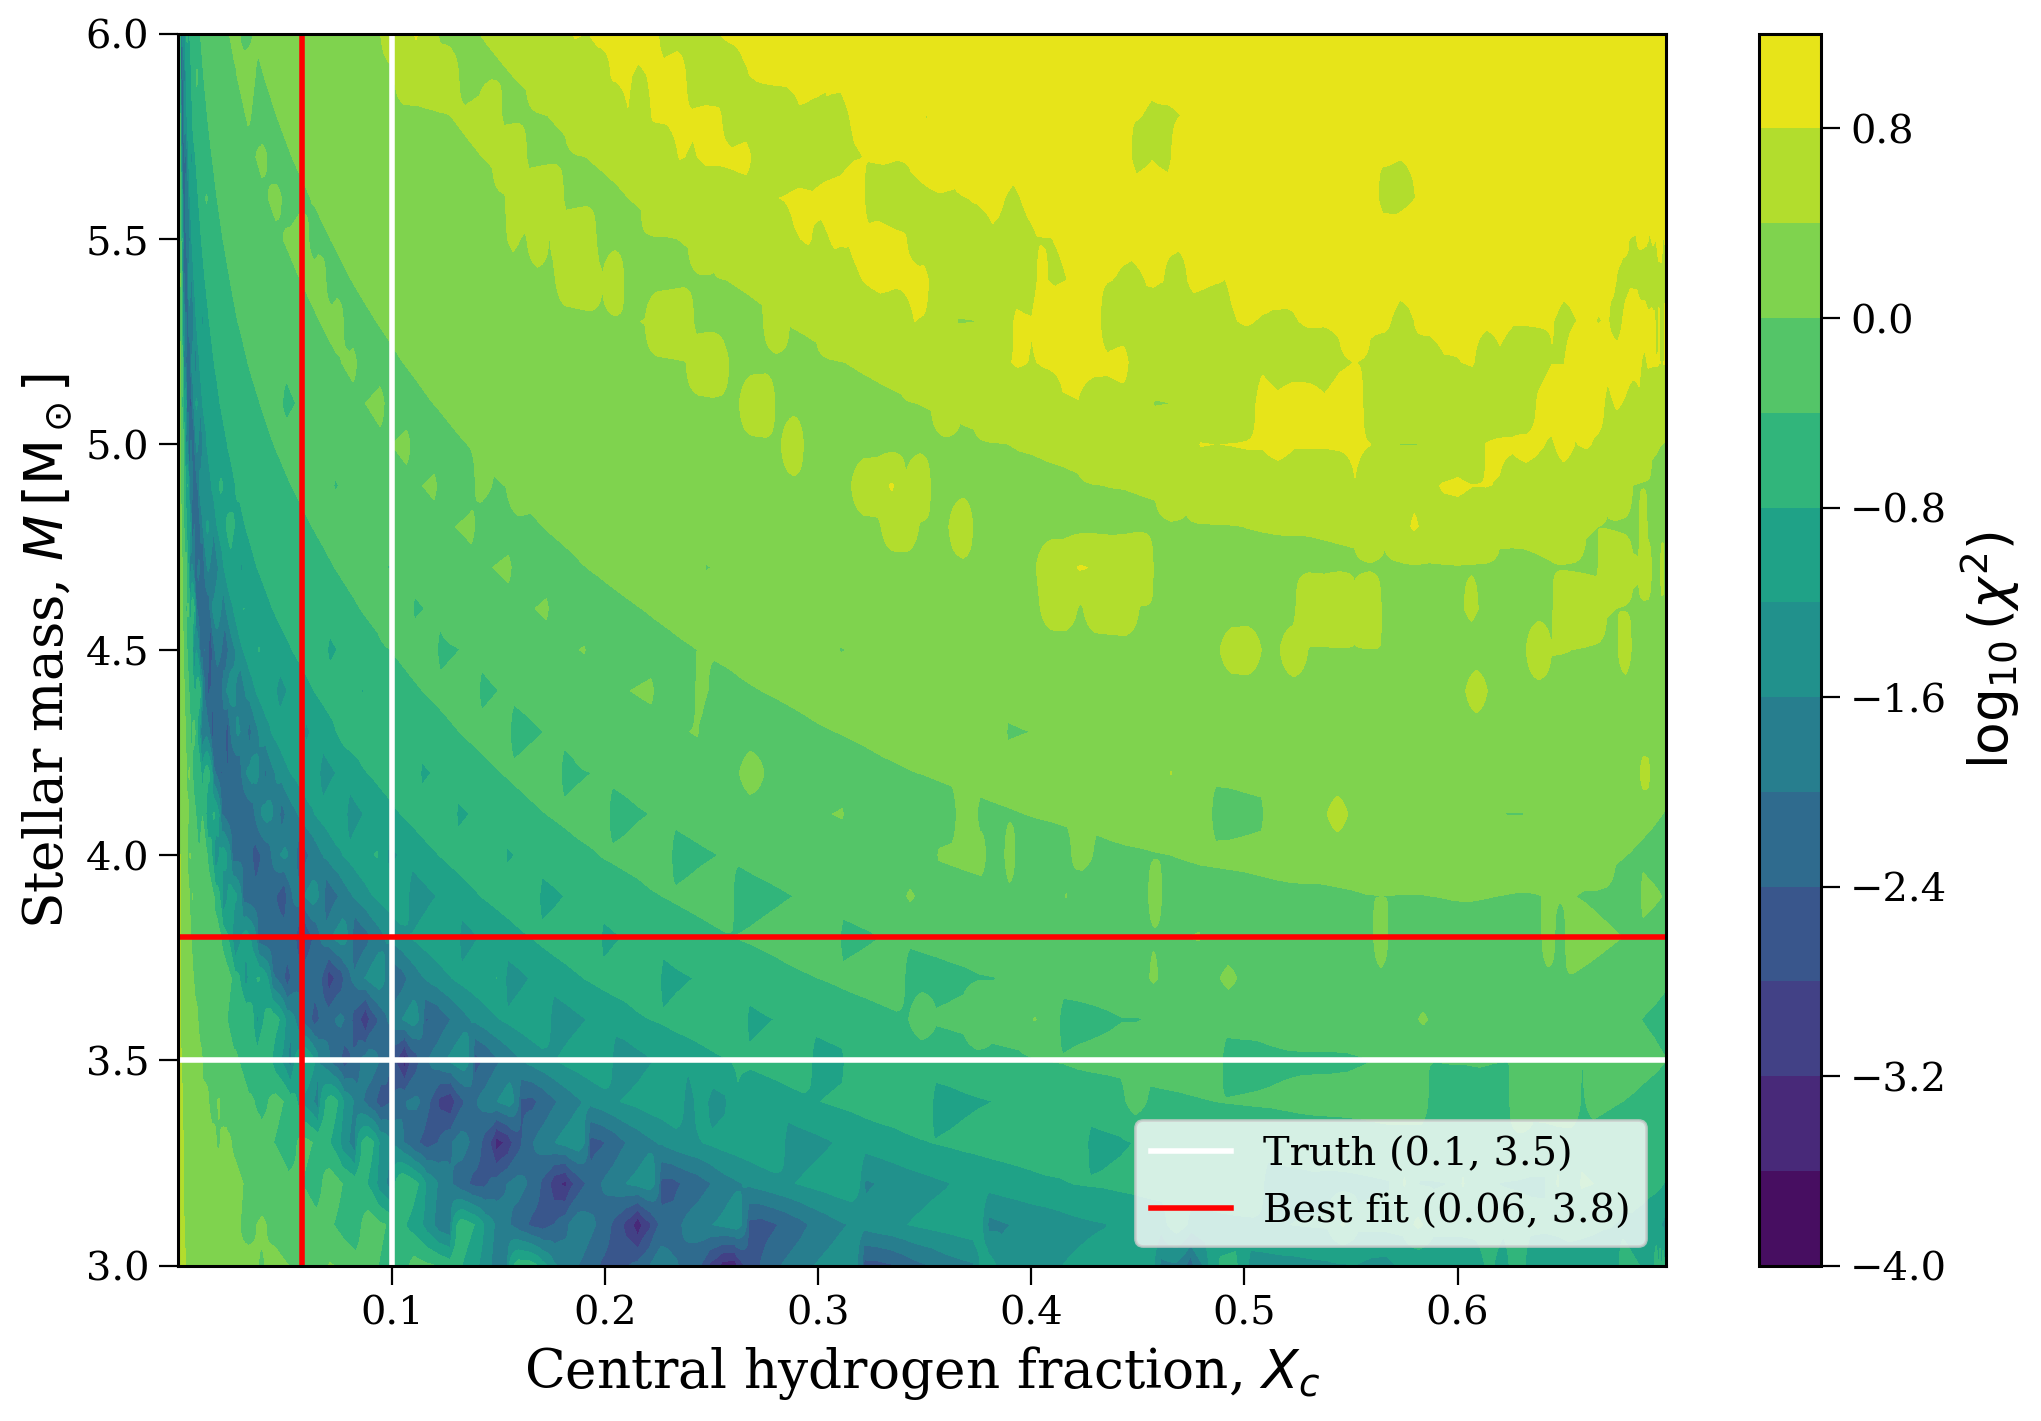

In [169]:
fig, ax = plt.subplots()

cont = ax.contourf(XC, M, np.log10(CHI), levels=15)
fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$")

plt.axvline(0.1, color="white", linestyle="-", lw=2, label="Truth (0.1, 3.5)")
plt.axhline(3.5, color="white", linestyle="-", lw=2)

M_ind, x_c_ind = np.unravel_index(np.argmin(CHI), CHI.shape)

plt.axvline(x_c_range[x_c_ind], color="red", linestyle="-", lw=2, label=f"Best fit ({x_c_range[x_c_ind]:1.2f}, {Ms[M_ind]:1.1f})")
plt.axhline(Ms[M_ind], color="red", linestyle="-", lw=2)

plt.legend(loc="lower right")

# for M in Ms:
#     plt.axhline(M, color="black")
# for x_c in x_c_range:
#     plt.axvline(x_c, color="black", lw=0.1)


ax.set_xlabel(r"Central hydrogen fraction, $X_c$")
ax.set_ylabel(r"Stellar mass, $M \, [\rm M_\odot]$")

plt.show()

# CHECK AGAINST COLE

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def generate_obs_series(periods,errors):
    observed_spacings        = []
    observed_spacings_errors = []

    for kk,prd_k in enumerate(periods[:-1]):
        prd_k_p_1 = periods[kk+1]
        observed_spacings.append( abs( prd_k - prd_k_p_1 )*86400. )
        observed_spacings_errors.append(np.sqrt( errors[kk]**2 + errors[kk+1]**2  )*86400.)
    return observed_spacings,observed_spacings_errors


def generate_thry_series(periods):

    theoretical_spacings = []

    for kk,prd_k in enumerate(periods[:-1]):
        prd_k_p_1 = periods[kk+1]
        theoretical_spacings.append( abs(prd_k-prd_k_p_1)*86400. )
    return theoretical_spacings


def chisq_period_series_interp(tperiods,tspacings,operiods,ospacings,ospacing_errors):
    interp = interp1d(tperiods[1:][::-1],np.array(tspacings[::-1]),kind='linear')(np.array(operiods[1:][::-1]))[::-1]
    chi = (np.array(interp)-np.array(ospacings))**2 / np.array(ospacing_errors)**2

    return np.sum(chi), interp


def chisq_experimental(tperiods,tspacings,orders,operiods,operiod_errors,ospacings,ospacing_errors):

	chisqs = []
	for ii,per in enumerate(operiods):
		chisqs.append([])
		for jj,tper in enumerate(tperiods):
			chi2 = (per-tper)**2 / operiod_errors[ii]**2
			chisqs[ii].append(chi2)

	for ii,per in enumerate(operiods):
		ind = np.where(chisqs[ii]==min(chisqs[ii]))[0]
		#print ind
		print('Obs/Thr/chi2/order: %f\t%f\t%f\t%i'%(per,tperiods[ind],chisqs[ii][ind],orders[ind]))


def chisq_longest_sequence_SAVE(tperiods,orders,operiods,operiods_errors):

    # Generate two series
    dP,e_dP = generate_obs_series(operiods,operiods_errors)
    deltaP  = generate_thry_series(tperiods)

    # Find the best matches per observed period
    pairs_orders = []
    for ii,period in enumerate(operiods):

        chisqs = np.array([ ( (period-tperiod)/operiods_errors[ii] )**2 for tperiod in tperiods  ])

        ## Locate the theoretical frequency (and accompanying order) with the best chi2
        min_ind = np.where( chisqs == min( chisqs ) )[0]
        best_match = tperiods[min_ind][0]
        best_order = orders[min_ind][0]

        ## Toss everything together for bookkeeping
        pairs_orders.append([period,best_match,int(best_order),chisqs[min_ind]])

    pairs_orders = np.array(pairs_orders)

	#plt.figure(1,figsize=(6.6957,6.6957))
	#plt.subplot(211)
	#plt.plot(pairs_orders[:,0],pairs_orders[:,1],'o')
	#plt.ylabel('$\\mathrm{Period \\,[d]}$',fontsize=20)
	#plt.subplot(212)
	#plt.plot(pairs_orders[:,0],pairs_orders[:,2],'o')
	#plt.ylabel('$\\mathrm{Radial \\, Order}$',fontsize=20)
	#plt.xlabel('$\\mathrm{Period \\,[d]}$',fontsize=20)

	#plt.show()


    sequences = []
	## Look through all pairs of obs and theoretical frequencies and
	## check if the next obs freqency has a corresponding theoretical frequency
	## with the consecutive radial order
    current = []
    for ii,sett in enumerate(pairs_orders[:-1]):
        if abs(sett[2]) == abs(pairs_orders[ii+1][2])+1:
            current.append(sett)
        else:
            current.append(sett)
            sequences.append(np.array(current).reshape(len(current),4))
            current = []

    len_list = np.array([len(x) for x in sequences])
    longest = np.where(len_list == max(len_list))[0] #[0]

	## Test if there really is one longest sequence
    if len(longest) == 1:
        lseq = sequences[longest[0]]

	## if not, pick, of all the sequences with the same length, the best based on chi2
    else:
        scores = [ np.sum(sequences[ii][:,-1])/len(sequences[ii]) for  ii in longest]
        min_score = np.where(scores == min(scores))[0][0]
        lseq = sequences[longest[min_score]]

    obs_ordering_ind = np.where(operiods == lseq[:,0][0])[0][0]
    thr_ordering_ind = np.where(tperiods == lseq[:,1][0])[0][0]

    thr_ordering_start = thr_ordering_ind - len(operiods[:obs_ordering_ind])
    thr_ordering_stop  = thr_ordering_ind + len(operiods[obs_ordering_ind:])

    ordered_theoretical_periods   = []
    corresponding_orders          = []

    for ii,oper in enumerate(operiods[:obs_ordering_ind]):
        tper  = tperiods[thr_ordering_start+ii]
        order = orders[thr_ordering_start+ii]
        #ordered_theoretical_periods_a.append(tper)
        ordered_theoretical_periods.append(tper)
        corresponding_orders.append(order)

    for ii,oper in enumerate(operiods[obs_ordering_ind:]):
        tper  = tperiods[thr_ordering_ind+ii]
        order = orders[thr_ordering_ind+ii]
        #ordered_theoretical_periods_b.append(tper)
        ordered_theoretical_periods.append(tper)
        corresponding_orders.append(order)

	#final_theoretical_periods = np.sort(np.hstack([ordered_theoretical_periods_a,ordered_theoretical_periods_b]))[::-1]
    final_theoretical_periods = np.array(ordered_theoretical_periods)

    obs_series,obs_series_errors = generate_obs_series(operiods,operiods_errors)
    thr_series = generate_thry_series(final_theoretical_periods)

    obs_series        = np.array(obs_series)
    obs_series_errors = np.array(obs_series_errors)
    thr_series        = np.array(thr_series)

    series_chi2 = np.sum( (obs_series-thr_series)**2 /obs_series_errors**2 ) / len(obs_series)
    # print 'orders: %i - %i'%(corresponding_orders[0],corresponding_orders[-1])

    fig = plt.figure(1,figsize=(6.6957,6.6957))
    fig.suptitle('$\mathrm{Longest \\ Sequence}$',fontsize=20)
    axT = fig.add_subplot(211)
    axT.errorbar(operiods[1:],obs_series,yerr=obs_series_errors,marker='x',color='black',label='Obs')
    axT.plot(final_theoretical_periods[1:],thr_series,'rx-',label='Theory')
    axT.set_ylabel('$\mathrm{Period \\ Spacing \\ (s)}$',fontsize=20)
    axT.legend(loc='best')
    axB = fig.add_subplot(212)
    axB.errorbar(operiods[1:],obs_series-thr_series,yerr=obs_series_errors,marker='',color='black')
    axB.set_ylabel('$\mathrm{Residuals \\ (s)}$',fontsize=20)
    axB.set_xlabel('$\mathrm{Period \\ (d^{-1})}$',fontsize=20)
    axB.text(0.75,0.85,'$\chi^2 = %.2f$'%series_chi2,fontsize=15,transform=axB.transAxes)

    plt.show()

    series_chi2 = np.sum( ( (obs_series-thr_series) /obs_series_errors )**2 ) / len(obs_series)
    return series_chi2,final_theoretical_periods,corresponding_orders


def chisq_longest_sequence(tperiods,orders,operiods,operiods_errors):
    if len(tperiods)<len(operiods):
        return 1e16, [-1. for i in range(len(operiods))], [-1 for i in range(len(operiods))]
    else:
        # Generate two series
        dP,e_dP = generate_obs_series(operiods,operiods_errors)
        deltaP  = generate_thry_series(tperiods)

        # Find the best matches per observed period
        pairs_orders = []
        for ii,period in enumerate(operiods):
            chisqs = np.array([ ( (period-tperiod)/operiods_errors[ii] )**2 for tperiod in tperiods  ])

            ## Locate the theoretical frequency (and accompanying order) with the best chi2
            min_ind = np.where( chisqs == min( chisqs ) )[0]
            best_match = tperiods[min_ind][0]
            best_order = orders[min_ind][0]

            ## Toss everything together for bookkeeping
            pairs_orders.append([period,best_match,int(best_order),chisqs[min_ind]])

        pairs_orders = np.array(pairs_orders)

        plt.figure(1,figsize=(6.6957,6.6957))
        plt.subplot(211)
        plt.plot(pairs_orders[:,0],pairs_orders[:,1],'o')
        plt.ylabel('$\\mathrm{Period \\,[d]}$',fontsize=20)
        plt.subplot(212)
        plt.plot(pairs_orders[:,0],pairs_orders[:,2],'o')
        plt.ylabel('$\\mathrm{Radial \\, Order}$',fontsize=20)
        plt.xlabel('$\\mathrm{Period \\,[d]}$',fontsize=20)

        # plt.show()


        sequences = []
        ## Look through all pairs of obs and theoretical frequencies and
        ## check if the next obs freqency has a corresponding theoretical frequency
        ## with the consecutive radial order
        current = []
        lp = len(pairs_orders[:-1])
        for ii,sett in enumerate(pairs_orders[:-1]):
            if abs(sett[2]) == abs(pairs_orders[ii+1][2])+1:
                    current.append(sett)
            else:
                current.append(sett)
                sequences.append(np.array(current).reshape(len(current),4))
                current = []
            if (ii==lp-1):
                current.append(sett)
                sequences.append(np.array(current).reshape(len(current),4))
                current = []
        len_list = np.array([len(x) for x in sequences])
        longest = np.where(len_list == max(len_list))[0] #[0]

        ## Test if there really is one longest sequence
        if len(longest) == 1:
            lseq = sequences[longest[0]]

        ## if not, pick, of all the sequences with the same length, the best based on chi2
        else:
            scores = [ np.sum(sequences[ii][:,-1])/len(sequences[ii]) for  ii in longest]
            min_score = np.where(scores == min(scores))[0][0]
            lseq = sequences[longest[min_score]]

        obs_ordering_ind = np.where(operiods == lseq[:,0][0])[0][0]
        thr_ordering_ind = np.where(tperiods == lseq[:,1][0])[0][0]

        ordered_theoretical_periods   = []
        corresponding_orders          = []

        thr_ind_start = thr_ordering_ind - obs_ordering_ind
        thr_ind_current = thr_ind_start

        for i,oper in enumerate(operiods):
            thr_ind_current = thr_ind_start + i
            if (thr_ind_current < 0):
                tper = -1
                ordr = -1
            elif (thr_ind_current >= len(tperiods)):
                tper = -1
                ordr = -1
            else:
                tper = tperiods[thr_ind_current]
                ordr = orders[thr_ind_current]
            ordered_theoretical_periods.append(tper)
            corresponding_orders.append(ordr)

        #final_theoretical_periods = np.sort(np.hstack([ordered_theoretical_periods_a,ordered_theoretical_periods_b]))[::-1]
        final_theoretical_periods = np.array(ordered_theoretical_periods)

        obs_series,obs_series_errors = generate_obs_series(operiods,operiods_errors)
        thr_series = generate_thry_series(final_theoretical_periods)

        obs_series        = np.array(obs_series)
        obs_series_errors = np.array(obs_series_errors)
        thr_series        = np.array(thr_series)

        series_chi2 = np.sum( (obs_series-thr_series)**2 /obs_series_errors**2 ) / len(obs_series)
        # print 'orders: %i - %i'%(corresponding_orders[0],corresponding_orders[-1])

        fig = plt.figure(2,figsize=(6.6957,6.6957))
        fig.suptitle('$\mathrm{Longest \\ Sequence}$',fontsize=20)
        axT = fig.add_subplot(211)
        # axT.errorbar(operiods[1:],obs_series,yerr=obs_series_errors,marker='x',color='black',label='Obs')
        # axT.plot(final_theoretical_periods[1:],thr_series,'rx-',label='Theory')
        axT.errorbar(range(len(obs_series)),obs_series,yerr=obs_series_errors,marker='x',color='black',label='Obs')
        axT.plot(range(len(thr_series)),thr_series,'rx-',label='Theory')
        axT.set_ylabel('$\mathrm{Period \\ Spacing \\ (s)}$',fontsize=20)
        axT.legend(loc='best')
        axB = fig.add_subplot(212)
        axB.errorbar(operiods[1:],obs_series-thr_series,yerr=obs_series_errors,marker='',color='black')
        axB.set_ylabel('$\mathrm{Residuals \\ (s)}$',fontsize=20)
        axB.set_xlabel('$\mathrm{Period \\ (d^{-1})}$',fontsize=20)
        axB.text(0.75,0.85,'$\chi^2 = %.2f$'%series_chi2,fontsize=15,transform=axB.transAxes)

        plt.show()

        for ii,oper in enumerate(operiods):
            print(oper, final_theoretical_periods[ii], corresponding_orders[ii])

        series_chi2 = np.sum( ( (obs_series-thr_series) /obs_series_errors )**2 ) / len(obs_series)
        return series_chi2,final_theoretical_periods,corresponding_orders


def chisq_best_sequence(tperiods,orders,operiods,operiods_errors):

    # Generate two series
    dP,e_dP = generate_obs_series(operiods,operiods_errors)
    deltaP  = generate_thry_series(tperiods)

    # Find the best matches per observed period
    pairs_orders = []
    for ii,period in enumerate(operiods):

        chisqs = np.array([ ( (period-tperiod)/operiods_errors[ii] )**2 for tperiod in tperiods  ])

        ## Locate the theoretical frequency (and accompanying order) with the best chi2
        min_ind = np.where( chisqs == min( chisqs ) )[0]#[0]
        best_match = tperiods[min_ind][0]
        best_order = orders[min_ind][0]

        ## Toss everything together for bookkeeping
        pairs_orders.append([period,best_match,int(best_order),chisqs[min_ind]])

    pairs_orders = np.array(pairs_orders)

    sequences = []
    ## Look through all pairs of obs and theoretical frequencies and
    ## check if the next obs freqency has a corresponding theoretical frequency
    ## with the consecutive radial order
    current = []
    for ii,sett in enumerate(pairs_orders[:-1]):
        if abs(sett[2]) == abs(pairs_orders[ii+1][2])+1:
        #print sett,'-->',pairs_orders[ii+1]
            current.append(sett)
        else:
            current.append(sett)
            #print 'BREAK', np.array(current)[:,2]
            sequences.append(np.array(current).reshape(len(current),4))
            current = []


    scores = [ np.sum(sequence[:,-1])/len(sequence) for sequence in sequences]
    min_score = np.where(scores == min(scores))[0][0]
    lseq = sequences[min_score]

    obs_ordering_ind = np.where(operiods == lseq[:,0][0])[0][0]
    thr_ordering_ind = np.where(tperiods == lseq[:,1][0])[0][0]

    thr_ordering_start = thr_ordering_ind - len(operiods[:obs_ordering_ind])
    thr_ordering_stop  = thr_ordering_ind + len(operiods[obs_ordering_ind:])

    ordered_theoretical_periods   = []
    corresponding_orders          = []

    for ii,oper in enumerate(operiods[:obs_ordering_ind]):
        tper  = tperiods[thr_ordering_start+ii]
        order = orders[thr_ordering_start+ii]
        ordered_theoretical_periods.append(tper)
        corresponding_orders.append(order)

    for ii,oper in enumerate(operiods[obs_ordering_ind:]):
        tper  = tperiods[thr_ordering_ind+ii]
        order = orders[thr_ordering_ind+ii]
        ordered_theoretical_periods.append(tper)
        corresponding_orders.append(order)

    final_theoretical_periods = np.array(ordered_theoretical_periods)


    obs_series,obs_series_errors = generate_obs_series(operiods,operiods_errors)
    thr_series = generate_thry_series(final_theoretical_periods)

    obs_series        = np.array(obs_series)
    obs_series_errors = np.array(obs_series_errors)
    thr_series        = np.array(thr_series)
    series_chi2 = np.sum( (obs_series-thr_series)**2 /obs_series_errors**2 ) / len(obs_series)



    fig = plt.figure(1,figsize=(6.6957,6.6957))
    fig.suptitle('$\mathrm{Best \\ \chi^2}$',fontsize=20)
    axT = fig.add_subplot(211)
    axT.errorbar(operiods[1:],obs_series,yerr=obs_series_errors,marker='x',color='black',label='Obs')
    axT.plot(final_theoretical_periods[1:],thr_series,'rx-',label='Theory')
    axT.set_ylabel('$\mathrm{Period \\ Spacing \\ (s)}$',fontsize=20)
    axT.legend(loc='best')
    axB = fig.add_subplot(212)
    axB.errorbar(operiods[1:],obs_series-thr_series,yerr=obs_series_errors,marker='',color='black')
    axB.set_ylabel('$\mathrm{Residuals \\ (s)}$',fontsize=20)
    axB.set_xlabel('$\mathrm{Period \\ (d^{-1})}$',fontsize=20)
    axB.text(0.75,0.85,'$\chi^2 = %.2f$'%series_chi2,fontsize=15,transform=axB.transAxes)

    plt.show()

    return series_chi2,final_theoretical_periods,corresponding_orders

In [ ]:
chisq_best_sequence(tperiods,orders,operiods,operiods_errors):

In [30]:
chisq_best_sequence(p_mg, np.arange(len(p_mg)), p_s, np.ones(len(p_s)) * 1e-5)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (36, 4) + inhomogeneous part.

In [26]:
p_s

array([1.05095948, 1.10511156, 1.16303194, 1.21594726, 1.27504338,
       1.3272443 , 1.3871063 , 1.43851282, 1.49903156, 1.54992979,
       1.61101852, 1.66108667, 1.7224215 , 1.77189812, 1.83332654,
       1.88240055, 1.9434894 , 1.99308876, 2.05369131, 2.10446825,
       2.16392225, 2.21612985, 2.27438533, 2.32806201, 2.38489444,
       2.4397479 , 2.49543121, 2.55122619, 2.60615833, 2.66254204,
       2.71724124, 2.77387795, 2.82844337, 2.8849265 , 2.93948317,
       2.99576213])

In [25]:
p_s = np.sort(p_s[(p_s.value > 1.0) & (p_s.value <= 3.0)].value)

In [29]:
p_mg = np.sort(p_mg[(p_mg.value > 1.0) & (p_mg.value <= 3.0)].value)